<a href="https://colab.research.google.com/github/mateuszxx89/computere-vision-course/blob/main/02_document_scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade opencv-python

In [2]:
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_local
import numpy as np
from numpy.linalg import norm
import imutils
import cv2
cv2.__version__

'4.10.0'

In [3]:
image = cv2.imread('paragon_1.jpg')
image.shape

(600, 450, 3)

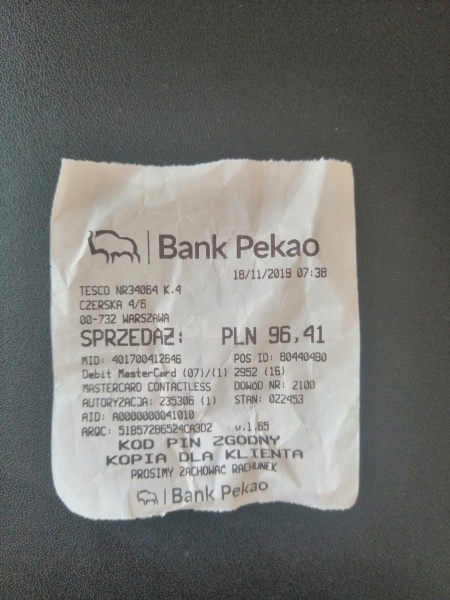

In [4]:
cv2_imshow(image)

In [5]:
original_image = image.copy()

ration = image.shape[0] /500.0

image = imutils.resize(image, height = 500)
image.shape

(500, 375, 3)

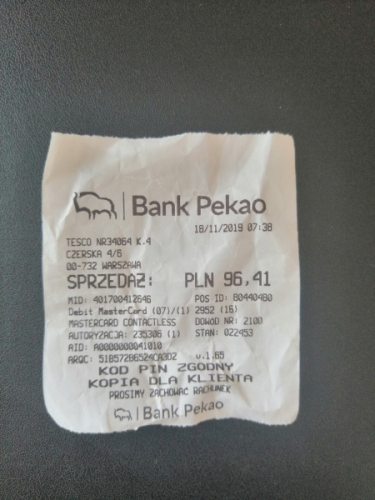

In [6]:
cv2_imshow(image)

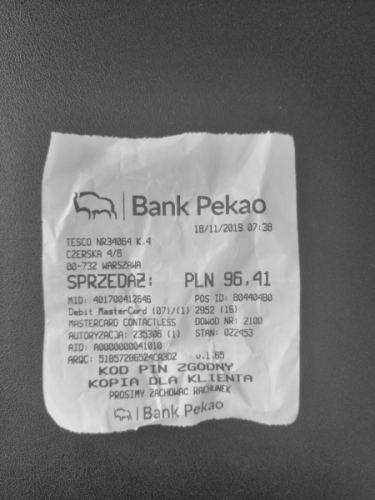

In [7]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)

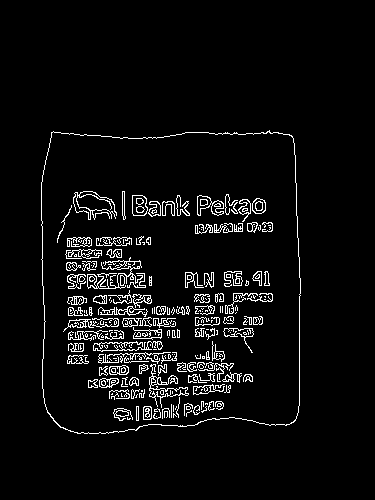

In [8]:
edges = cv2.Canny(gray_image, threshold1=75, threshold2=200)
cv2_imshow(edges)

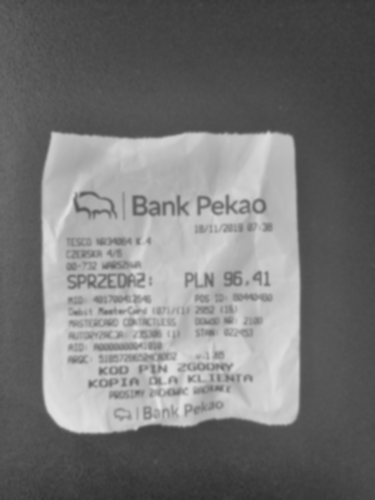

In [9]:
gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
cv2_imshow(gray_image)

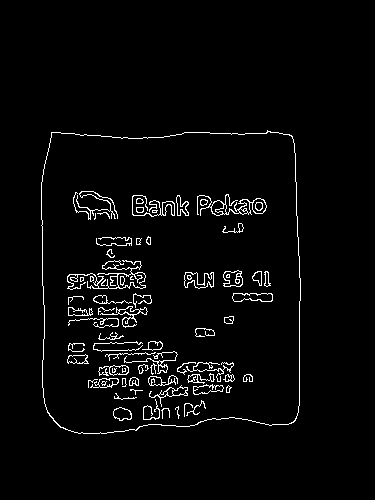

In [10]:
edges = cv2.Canny(gray_image, threshold1=75, threshold2=200)
cv2_imshow(edges)

In [11]:
contours = cv2.findContours(image=edges.copy(), mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
print(f'Liczba wszystkich wyszukanych punktów (kontur): {len(contours)}')
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

for contour in contours:
  print(len(contour))

Liczba wszystkich wyszukanych punktów (kontur): 135
217
215
189
356
83


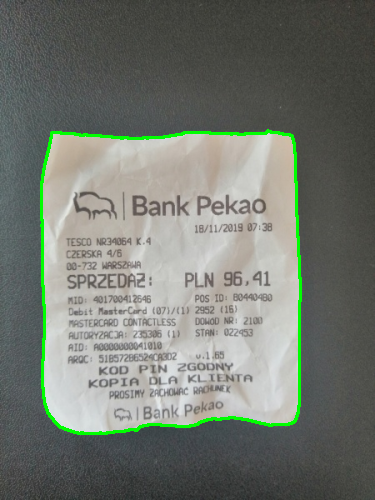

In [12]:
cnt1 = cv2.drawContours(image.copy(), [contours[0]], -1, (0, 255, 0), 2)
cv2_imshow(cnt1)

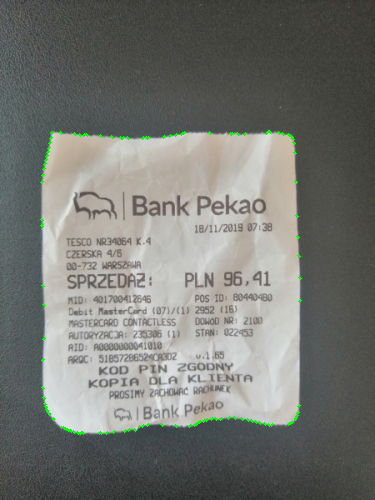

In [14]:
cnt2 = cv2.drawContours(image.copy(), contours[1], -1, (0, 255, 0), 2)
cv2_imshow(cnt2)

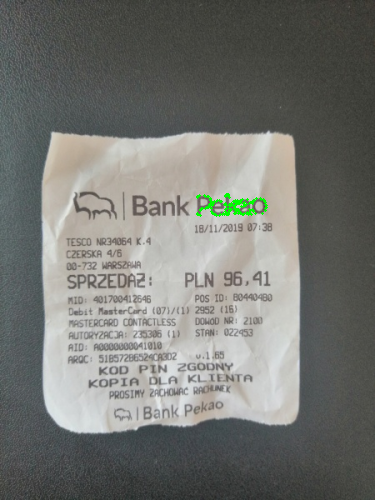

In [16]:
cnt3 = cv2.drawContours(image.copy(), contours[2], -1, (0, 255, 0), 2)
cv2_imshow(cnt3)

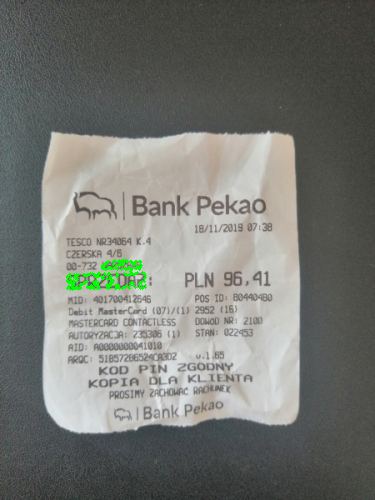

In [17]:
cnt4 = cv2.drawContours(image.copy(), contours[3], -1, (0, 255, 0), 2)
cv2_imshow(cnt4)

In [18]:
for contour in contours:
  print('Sprawdzenie...')
  perimeter = cv2.arcLength(curve=contour, closed=True)
  approx = cv2.approxPolyDP(curve=contour, epsilon=0.02*perimeter, closed=True)

  if len(approx) == 4:
    screen_contour = approx
    break

print(screen_contour)

Sprawdzenie...
[[[291 135]]

 [[ 51 132]]

 [[ 60 427]]

 [[295 420]]]


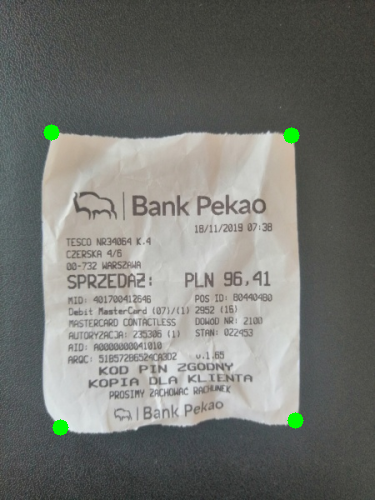

In [19]:
cv2.drawContours(image, screen_contour, -1, (0, 255, 0), 15)
cv2_imshow(image)

In [20]:
points = screen_contour.reshape(4, 2)
points = points * ration
points

array([[349.2, 162. ],
       [ 61.2, 158.4],
       [ 72. , 512.4],
       [354. , 504. ]])

In [21]:
rectangle = np.zeros((4, 2), dtype='float32')
rectangle

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [22]:
total = points.sum(axis=1)

rectangle[0] = points[np.argmin(total)]
rectangle[2] = points[np.argmax(total)]
rectangle

array([[ 61.2, 158.4],
       [  0. ,   0. ],
       [354. , 504. ],
       [  0. ,   0. ]], dtype=float32)

In [23]:
difference = np.diff(points, axis=1)

rectangle[1] = points[np.argmin(difference)]
rectangle[3] = points[np.argmax(difference)]
rectangle

array([[ 61.2, 158.4],
       [349.2, 162. ],
       [354. , 504. ],
       [ 72. , 512.4]], dtype=float32)

In [24]:
(a,b,c,d) = rectangle

width1 = norm(c-d)
width2 = norm(a-b)
max_width = max(int(width1), int(width2))

height1 = norm(c-a)
height2 = norm(d-b)
max_height = max(int(height1), int(height2))

print(f'max_width: {max_width}')
print(f'max_height: {max_height}')

max_width: 288
max_height: 452


In [26]:
vertices = np.array([
  [0, 0],
  [max_width - 1, 0],
  [max_width - 1, max_height - 1],
  [0, max_height - 1]
], dtype = 'float32'
)
vertices

array([[  0.,   0.],
       [287.,   0.],
       [287., 451.],
       [  0., 451.]], dtype=float32)

In [27]:
M = cv2.getPerspectiveTransform(rectangle, vertices)
M

array([[ 9.47714238e-01, -2.89133112e-02, -5.34202438e+01],
       [-1.53665536e-02,  1.22932226e+00, -1.93784205e+02],
       [-1.16837074e-04, -5.27577239e-05,  1.00000000e+00]])

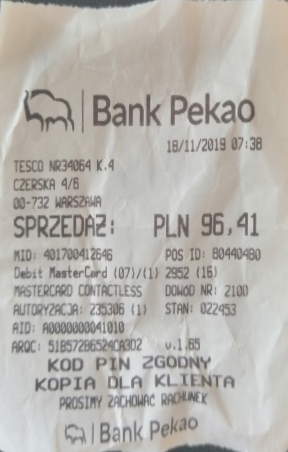

In [28]:
out = cv2.warpPerspective(original_image, M, (max_width, max_height))
cv2_imshow(out)

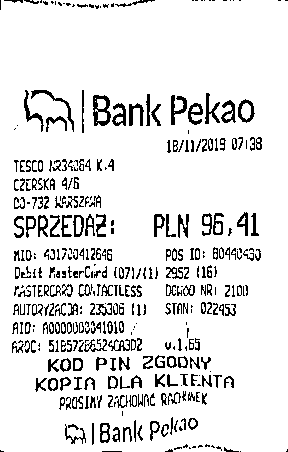

In [29]:
out = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
T=threshold_local(image=out, block_size=11, offset=10, method='gaussian')
out = (out > T).astype('uint8') * 255
cv2_imshow(out)